In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/nyse/securities.csv
/kaggle/input/nyse/fundamentals.csv
/kaggle/input/nyse/prices-split-adjusted.csv
/kaggle/input/nyse/prices.csv


In [2]:
import numpy as np 
import pandas as pd 

from subprocess import check_output

import keras
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import LSTM , GRU
from sklearn.model_selection import  train_test_split
import time 
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from math import sqrt

import matplotlib.pyplot as plt
from numpy import newaxis

import math, time # Helper Libraries

Using TensorFlow backend.


In [3]:
prices =  pd.read_csv('../input/nyse/prices-split-adjusted.csv', index_col = 0)
print(type(prices))
prices

<class 'pandas.core.frame.DataFrame'>


,symbol,open,close,low,high,volume
date,,,,,,
2016-01-05,WLTW,123.430000,125.839996,122.309998,126.250000,2163600.0
2016-01-06,WLTW,125.239998,119.980003,119.940002,125.540001,2386400.0
2016-01-07,WLTW,116.379997,114.949997,114.930000,119.739998,2489500.0
2016-01-08,WLTW,115.480003,116.620003,113.500000,117.440002,2006300.0
2016-01-11,WLTW,117.010002,114.970001,114.089996,117.330002,1408600.0
...,...,...,...,...,...,...
2016-12-30,ZBH,103.309998,103.199997,102.849998,103.930000,973800.0
2016-12-30,ZION,43.070000,43.040001,42.689999,43.310001,1938100.0
2016-12-30,ZTS,53.639999,53.529999,53.270000,53.740002,1701200.0


In [4]:
prices.shape

(851264, 6)

In [5]:
prices.head()

,symbol,open,close,low,high,volume
date,,,,,,
2016-01-05,WLTW,123.430000,125.839996,122.309998,126.250000,2163600.0
2016-01-06,WLTW,125.239998,119.980003,119.940002,125.540001,2386400.0
2016-01-07,WLTW,116.379997,114.949997,114.930000,119.739998,2489500.0
2016-01-08,WLTW,115.480003,116.620003,113.500000,117.440002,2006300.0
2016-01-11,WLTW,117.010002,114.970001,114.089996,117.330002,1408600.0


In [6]:
prices.describe()

,open,close,low,high,volume
count,851264.000000,851264.000000,851264.000000,851264.000000,8.512640e+05
mean,64.993618,65.011913,64.336541,65.639748,5.415113e+06
std,75.203893,75.201216,74.459518,75.906861,1.249468e+07
min,1.660000,1.590000,1.500000,1.810000,0.000000e+00
25%,31.270000,31.292776,30.940001,31.620001,1.221500e+06
50%,48.459999,48.480000,47.970001,48.959999,2.476250e+06
75%,75.120003,75.139999,74.400002,75.849998,5.222500e+06
max,1584.439941,1578.130005,1549.939941,1600.930054,8.596434e+08


In [7]:
prices.groupby('symbol').count()

,open,close,low,high,volume
symbol,,,,,
A,1762,1762,1762,1762,1762
AAL,1762,1762,1762,1762,1762
AAP,1762,1762,1762,1762,1762
AAPL,1762,1762,1762,1762,1762
ABBV,1008,1008,1008,1008,1008
...,...,...,...,...,...
YHOO,1762,1762,1762,1762,1762
YUM,1762,1762,1762,1762,1762
ZBH,1762,1762,1762,1762,1762


In [8]:
prices.info()

<class 'pandas.core.frame.DataFrame'>
Index: 851264 entries, 2016-01-05 to 2016-12-30
Data columns (total 6 columns):
symbol    851264 non-null object
open      851264 non-null float64
close     851264 non-null float64
low       851264 non-null float64
high      851264 non-null float64
volume    851264 non-null float64
dtypes: float64(5), object(1)
memory usage: 45.5+ MB


In [9]:
#  Number of Different Stocks
print('  Number of Different Stocks : ', len(list(set(prices.symbol))))

  Number of Different Stocks :  501


In [10]:
#  Number of Unique Ticker Symbols
print(set(prices['symbol']))

{'CI', 'AMT', 'DFS', 'SE', 'DOW', 'HRB', 'ABT', 'NVDA', 'FLS', 'ED', 'LNC', 'TXN', 'DUK', 'HP', 'LOW', 'RIG', 'TSN', 'MPC', 'MNST', 'BAX', 'PLD', 'WU', 'FB', 'ALB', 'WAT', 'GRMN', 'TMK', 'EQR', 'EXC', 'PRU', 'CHRW', 'DAL', 'GPS', 'CMA', 'LNT', 'AJG', 'KMB', 'ORCL', 'FITB', 'VTR', 'SIG', 'CVX', 'LLTC', 'PSA', 'IRM', 'TIF', 'EXPE', 'COH', 'INTC', 'AEP', 'UDR', 'WDC', 'ROK', 'USB', 'EBAY', 'IP', 'MCHP', 'VIAB', 'UAA', 'MTB', 'TRV', 'NFX', 'ESRX', 'CAT', 'SLG', 'CTSH', 'FSLR', 'CCI', 'CMI', 'AAL', 'FE', 'R', 'C', 'PPL', 'ADBE', 'DOV', 'GOOGL', 'KHC', 'AIG', 'GILD', 'LLY', 'HRL', 'SCHW', 'NI', 'ES', 'HAL', 'F', 'LH', 'APA', 'GM', 'ABBV', 'UTX', 'DD', 'EMR', 'CHK', 'D', 'MMM', 'BMY', 'LEG', 'AXP', 'FTV', 'NDAQ', 'V', 'PNW', 'GT', 'AMP', 'CMCSA', 'BHI', 'BLL', 'VRTX', 'IFF', 'TWX', 'WFM', 'PHM', 'ALLE', 'SNA', 'NEM', 'YUM', 'NTAP', 'STZ', 'FDX', 'TAP', 'EMN', 'WLTW', 'SNI', 'TROW', 'WMB', 'HUM', 'APD', 'PCG', 'XEL', 'MA', 'RAI', 'JWN', 'KR', 'IDXX', 'XRAY', 'ENDP', 'WBA', 'FOXA', 'BBY', 'ESS'

In [11]:
prices['symbol'].value_counts()

DRI     1762
PHM     1762
F       1762
AXP     1762
LMT     1762
        ... 
PYPL     378
HPE      304
CSRA     284
WLTW     251
FTV      126
Name: symbol, Length: 501, dtype: int64

In [12]:
# Extracting A Particular Price for Stock in Symbols
#  Using CSCO As An Example
prices[prices["symbol"] == "CSCO"].tail()

,symbol,open,close,low,high,volume
date,,,,,,
2016-12-23,CSCO,30.540001,30.530001,30.400000,30.600000,9167500.0
2016-12-27,CSCO,30.639999,30.680000,30.600000,30.820000,14175500.0
2016-12-28,CSCO,30.700001,30.420000,30.350000,30.770000,12022200.0
2016-12-29,CSCO,30.370001,30.459999,30.330000,30.549999,10995600.0
2016-12-30,CSCO,30.559999,30.219999,30.129999,30.600000,20190000.0


In [13]:
cisc = prices[prices['symbol']=='CSCO']
cisc.shape

(1762, 6)

In [14]:
cisco = prices[prices['symbol']=='CSCO']
print(cisco)
print(type(cisco))
print(cisco.close.values)
cisco_stock_prices = cisco.close.values.astype('float32')
cisco_stock_prices = cisco_stock_prices.reshape(1762, 1)
cisco_stock_prices.shape

           symbol       open      close        low       high      volume
date                                                                     
2010-01-04   CSCO  24.110001  24.690001  24.010000  24.840000  59853700.0
2010-01-05   CSCO  24.600000  24.580000  24.379999  24.730000  45124500.0
2010-01-06   CSCO  24.540001  24.420000  24.340000  24.740000  35715700.0
2010-01-07   CSCO  24.299999  24.530001  24.170000  24.570000  31531200.0
2010-01-08   CSCO  24.379999  24.660000  24.250000  24.700001  39115900.0
...           ...        ...        ...        ...        ...         ...
2016-12-23   CSCO  30.540001  30.530001  30.400000  30.600000   9167500.0
2016-12-27   CSCO  30.639999  30.680000  30.600000  30.820000  14175500.0
2016-12-28   CSCO  30.700001  30.420000  30.350000  30.770000  12022200.0
2016-12-29   CSCO  30.370001  30.459999  30.330000  30.549999  10995600.0
2016-12-30   CSCO  30.559999  30.219999  30.129999  30.600000  20190000.0

[1762 rows x 6 columns]
<class 'panda

(1762, 1)

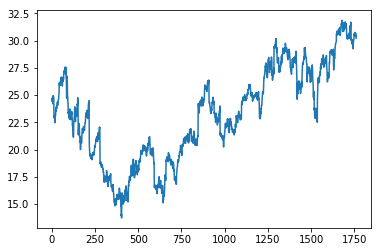

In [15]:
plt.plot(cisco_stock_prices)
plt.show()

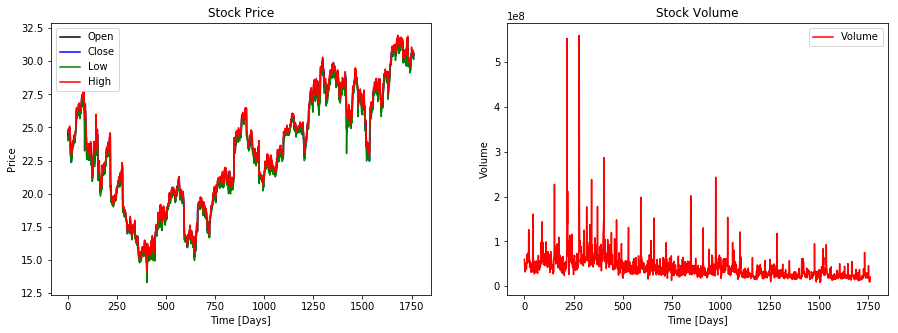

In [16]:
plt.figure(figsize=(15, 5));
plt.subplot(1,2,1);
plt.plot(prices[prices.symbol == 'CSCO'].open.values, color='black', label='Open')
plt.plot(prices[prices.symbol == 'CSCO'].close.values, color='blue', label='Close')
plt.plot(prices[prices.symbol == 'CSCO'].low.values, color='green', label='Low')
plt.plot(prices[prices.symbol == 'CSCO'].high.values, color='red', label='High')
plt.title('Stock Price')
plt.xlabel('Time [Days]')
plt.ylabel('Price')
plt.legend(loc='best')

plt.subplot(1,2,2);
plt.plot(prices[prices.symbol == 'CSCO'].volume.values, color='red', label='Volume')
plt.title('Stock Volume')
plt.xlabel('Time [Days]')
plt.ylabel('Volume')
plt.legend(loc='best');

In [17]:
# Selection of CISCO As The Stock to Analyse
prices = prices[prices.symbol == 'CSCO']
prices.drop(['symbol'],1,inplace=True)
prices.head()

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,open,close,low,high,volume
date,,,,,
2010-01-04,24.110001,24.690001,24.010000,24.840000,59853700.0
2010-01-05,24.600000,24.580000,24.379999,24.730000,45124500.0
2010-01-06,24.540001,24.420000,24.340000,24.740000,35715700.0
2010-01-07,24.299999,24.530001,24.170000,24.570000,31531200.0
2010-01-08,24.379999,24.660000,24.250000,24.700001,39115900.0


In [18]:
cols = list(prices.columns.values)
print('prices.columns.values = ', cols)

prices.columns.values =  ['open', 'close', 'low', 'high', 'volume']


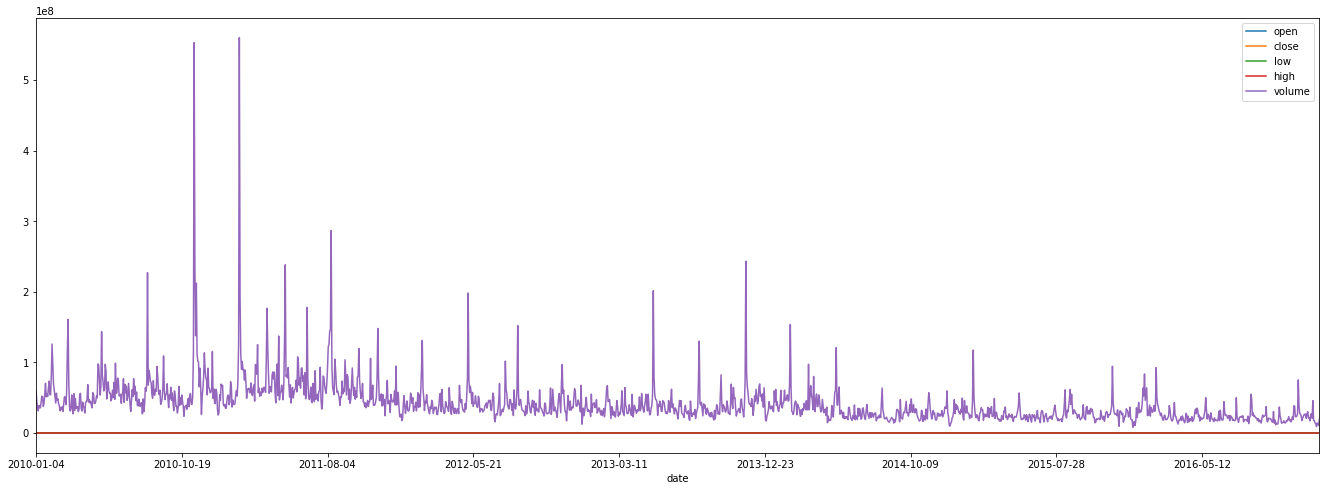

In [19]:
prices.plot(figsize=(23,8))

In [20]:
prices.isna().sum()

open      0
close     0
low       0
high      0
volume    0
dtype: int64

In [21]:
prices.describe()

,open,close,low,high,volume
count,1762.000000,1762.000000,1762.000000,1762.000000,1.762000e+03
mean,23.238655,23.246436,23.036771,23.447395,4.198613e+07
std,4.343675,4.353713,4.333605,4.362779,3.089350e+07
min,13.930000,13.730000,13.300000,14.120000,8.166300e+06
25%,19.840000,19.830000,19.662500,19.959999,2.536715e+07
50%,23.245000,23.245000,22.990000,23.500000,3.529625e+07
75%,26.927500,26.879999,26.655000,27.170000,5.017315e+07
max,31.930000,31.870001,31.750000,31.950001,5.600402e+08


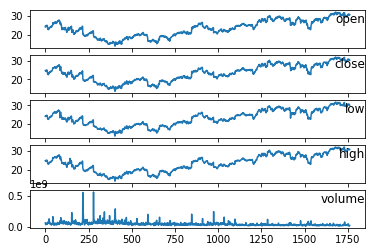

In [22]:
data = prices.values
# Specifying Columns to Plot
features = [0, 1, 2, 3, 4]
i = 1
# Plotting Each Column
plt.figure()
for feature in features:
    plt.subplot(len(features), 1, i)
    plt.plot(data[:, feature])
    plt.title(prices.columns[feature], y=0.5, loc='right')
    i += 1
plt.show()

In [23]:
#  Moving close To The Last Column
prices["fix_close"] = prices.close
#  Moving close To The Last Column
prices.drop(['close'], 1, inplace=True)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [24]:
prices.tail(5)

,open,low,high,volume,fix_close
date,,,,,
2016-12-23,30.540001,30.400000,30.600000,9167500.0,30.530001
2016-12-27,30.639999,30.600000,30.820000,14175500.0,30.680000
2016-12-28,30.700001,30.350000,30.770000,12022200.0,30.420000
2016-12-29,30.370001,30.330000,30.549999,10995600.0,30.459999
2016-12-30,30.559999,30.129999,30.600000,20190000.0,30.219999


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/s

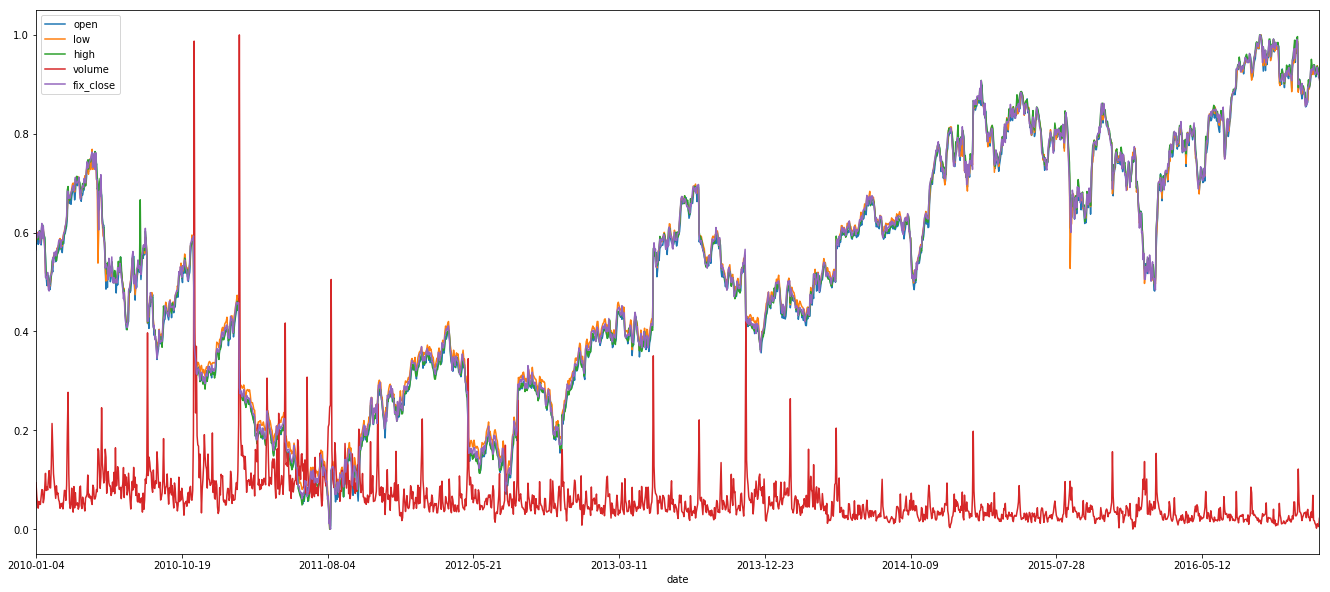

In [25]:
#  Normalizing The Data
#  Function for Min-Max Normalization of Stock
def normalize_data(prices):
    min_max_scaler = preprocessing.MinMaxScaler()
    prices['open'] = min_max_scaler.fit_transform(prices.open.values.reshape(-1,1))
    prices['high'] = min_max_scaler.fit_transform(prices.high.values.reshape(-1,1))
    prices['low'] = min_max_scaler.fit_transform(prices.low.values.reshape(-1,1))
    prices['volume'] = min_max_scaler.fit_transform(prices.volume.values.reshape(-1,1))
    prices['fix_close'] = min_max_scaler.fit_transform(prices['fix_close'].values.reshape(-1,1))
    return prices
prices = normalize_data(prices)
prices.plot(figsize=(23,10))

In [26]:
prices = normalize_data(prices)
prices.head()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/s

,open,low,high,volume,fix_close
date,,,,,
2010-01-04,0.565556,0.580488,0.601234,0.093658,0.604190
2010-01-05,0.592778,0.600542,0.595064,0.066969,0.598126
2010-01-06,0.589444,0.598374,0.595625,0.049920,0.589305
2010-01-07,0.576111,0.589160,0.586091,0.042337,0.595369
2010-01-08,0.580555,0.593496,0.593382,0.056081,0.602536


In [27]:
prices.describe()

,open,low,high,volume,fix_close
count,1762.000000,1762.000000,1762.000000,1762.000000,1762.000000
mean,0.517147,0.527738,0.523129,0.061282,0.524611
std,0.241315,0.234884,0.244688,0.055979,0.240006
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.328333,0.344851,0.327538,0.031168,0.336273
50%,0.517500,0.525203,0.526080,0.049160,0.524531
75%,0.722083,0.723848,0.731912,0.076117,0.724917
max,1.000000,1.000000,1.000000,1.000000,1.000000


In [28]:
#  Dropping Feature: volume
prices.drop(['volume'],1,inplace=True)

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [29]:
prices.tail()

,open,low,high,fix_close
date,,,,
2016-12-23,0.922778,0.926829,0.924285,0.926130
2016-12-27,0.928333,0.937669,0.936624,0.934399
2016-12-28,0.931667,0.924119,0.933819,0.920066
2016-12-29,0.913333,0.923035,0.921481,0.922271
2016-12-30,0.923889,0.912195,0.924285,0.909041


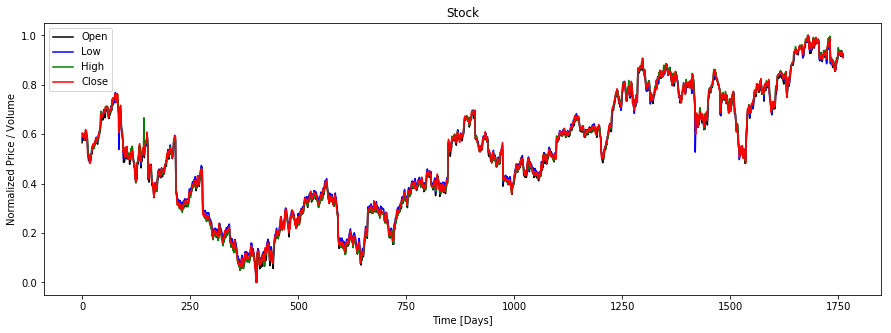

In [30]:
plt.figure(figsize=(15, 5));
plt.plot(prices.open.values, color='black', label='Open')
plt.plot(prices.low.values, color='blue', label='Low')
plt.plot(prices.high.values, color='green', label='High')
plt.plot(prices.fix_close.values, color='red', label='Close')

plt.title('Stock')
plt.xlabel('Time [Days]')
plt.ylabel('Normalized Price / Volume')
plt.legend(loc='best')
plt.show()

In [31]:
#  Function To Create Train, Validation, & Test Data Given Stock Data & Sequence Length
def training_data(stock, seq_len):
    #  4
    no_of_features = len(stock.columns)
    data = stock.as_matrix() 
    #  Index Starting From 0
    sequence_length = seq_len + 1
    result = []
    
    #  Creating All Possible Sequences of Length seq_len
    #  Maxmimum Date = Final Date - Sequence Length
    for index in range(len(data) - sequence_length):
        #  Index : Index + 22 Days
        result.append(data[index: index + sequence_length])
    
    result = np.array(result)
    # Split 90%
    row = round(0.9 * result.shape[0])
    # 90% Date, All Features
    train = result[:int(row), :]
    
    X_train = train[:, :-1] 
    y_train = train[:, -1][:,-1]
    
    X_test = result[int(row):, :-1] 
    y_test = result[int(row):, -1][:,-1]

    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], no_of_features))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], no_of_features))  

    return [X_train, y_train, X_test, y_test]

In [32]:
#  Building The Structure of Model
#  LSTM with GRU Cells
#  Parameters
#  dropout = 0.3
#  epochs = 90
#  LSTM 256 
#  GRU 256 -> LSTM 256 -> Relu 64
def build_model(layers):
    d = 0.3
    model = Sequential()
    model.add(GRU(256, input_shape = (layers[1], layers[0]) , return_sequences=True))
    model.add(Dropout(d))
    model.add(LSTM(256))
    model.add(Dropout(d))
    model.add(Dense(64 ,  activation = 'relu'))
    model.add(Dense(1))
    print(model.summary())
    start = time.time()
    model.compile(loss='mean_squared_error', optimizer=Adam(lr = 0.0005) , metrics = ['mean_squared_error'])
    print("Compilation Time : ", time.time() - start)
    return model

In [33]:
#  Training The Model
window = 60
X_train, y_train, X_test, y_test = training_data(prices, window)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """


In [34]:
print('X_train Shape = ',X_train.shape)
print('y_train Shape = ', y_train.shape)
print('X_test Shape = ', X_test.shape)
print('y_test Shape = ',y_test.shape)

X_train Shape =  (1531, 60, 4)
y_train Shape =  (1531,)
X_test Shape =  (170, 60, 4)
y_test Shape =  (170,)


In [35]:
print (X_train[0], y_train[0])

[[0.56555561 0.5804878  0.60123384 0.60418966]
 [0.59277778 0.60054195 0.59506446 0.59812566]
 [0.5894445  0.59837398 0.59562532 0.58930537]
 [0.57611106 0.58915989 0.58609083 0.59536937]
 [0.5805555  0.59349593 0.59338196 0.6025358 ]
 [0.59499994 0.60216802 0.60403805 0.59867692]
 [0.58388894 0.58428184 0.58216486 0.57717753]
 [0.57500006 0.59078596 0.59338196 0.60143321]
 [0.59166667 0.60813008 0.6146943  0.61852262]
 [0.615      0.59620591 0.61581601 0.58820283]
 [0.5894445  0.60704607 0.6034772  0.61300989]
 [0.59388894 0.58644992 0.59506446 0.5887541 ]
 [0.58777778 0.57235778 0.59057764 0.56504958]
 [0.55055556 0.51869924 0.55019627 0.50937147]
 [0.50944444 0.51165312 0.50813233 0.51047406]
 [0.49277772 0.50623301 0.50925409 0.50551265]
 [0.49777772 0.51273713 0.51261915 0.51929435]
 [0.51388889 0.49051491 0.51037569 0.48456447]
 [0.50111117 0.49539301 0.50532801 0.48180808]
 [0.48444444 0.49214087 0.49467193 0.4961411 ]
 [0.49333328 0.49918699 0.50420642 0.51212787]
 [0.51277778 

In [36]:
model = build_model([4,window,1])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 60, 256)           200448    
_________________________________________________________________
dropout_1 (Dropout)          (None, 60, 256)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 256)               525312    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 742,273
Trainable params: 742,273
Non-trainable params: 0
________________________________________________

In [37]:
#  Fitting The Model
model.fit(X_train,y_train,batch_size=512,epochs=90,validation_split=0.1,verbose=1)

Train on 1377 samples, validate on 154 samples
Epoch 1/90
1377/1377 [==============================] - 9s 6ms/step - loss: 0.1668 - mean_squared_error: 0.1668 - val_loss: 0.0258 - val_mean_squared_error: 0.0258
Epoch 2/90
1377/1377 [==============================] - 7s 5ms/step - loss: 0.0308 - mean_squared_error: 0.0308 - val_loss: 0.0056 - val_mean_squared_error: 0.0056
Epoch 3/90
1377/1377 [==============================] - 7s 5ms/step - loss: 0.0076 - mean_squared_error: 0.0076 - val_loss: 0.0396 - val_mean_squared_error: 0.0396
Epoch 4/90
1377/1377 [==============================] - 7s 5ms/step - loss: 0.0173 - mean_squared_error: 0.0173 - val_loss: 0.0135 - val_mean_squared_error: 0.0135
Epoch 5/90
1377/1377 [==============================] - 7s 5ms/step - loss: 0.0050 - mean_squared_error: 0.0050 - val_loss: 0.0080 - val_mean_squared_error: 0.0080
Epoch 6/90
1377/1377 [==============================] - 7s 5ms/step - loss: 0.0090 - mean_squared_error: 0.0090 - val_loss: 0.0047 - 

1377/1377 [==============================] - 7s 5ms/step - loss: 0.0021 - mean_squared_error: 0.0021 - val_loss: 0.0025 - val_mean_squared_error: 0.0025
Epoch 51/90
1377/1377 [==============================] - 7s 5ms/step - loss: 0.0021 - mean_squared_error: 0.0021 - val_loss: 0.0024 - val_mean_squared_error: 0.0024
Epoch 52/90
1377/1377 [==============================] - 7s 5ms/step - loss: 0.0021 - mean_squared_error: 0.0021 - val_loss: 0.0024 - val_mean_squared_error: 0.0024
Epoch 53/90
1377/1377 [==============================] - 7s 5ms/step - loss: 0.0018 - mean_squared_error: 0.0018 - val_loss: 0.0024 - val_mean_squared_error: 0.0024
Epoch 54/90
1377/1377 [==============================] - 7s 5ms/step - loss: 0.0020 - mean_squared_error: 0.0020 - val_loss: 0.0024 - val_mean_squared_error: 0.0024
Epoch 55/90
1377/1377 [==============================] - 7s 5ms/step - loss: 0.0018 - mean_squared_error: 0.0018 - val_loss: 0.0023 - val_mean_squared_error: 0.0023
Epoch 56/90
1377/1377 

In [38]:
difference = []
ratio = []
pred = model.predict(X_test)
print (pred.shape)

#  For Each Data Index in Test Data
for i in range(len(y_test)):
    #  pr = Prediction Day i
    pr = pred[i][0]
    #  (y_test day i / pr) - 1
    ratio.append((y_test[i]/pr)-1)
    difference.append(abs(y_test[i]- pr))

(170, 1)


In [40]:
#  Denormalizing The Data
prices = pd.read_csv("../input/nyse/prices-split-adjusted.csv", index_col = 0)
prices["fix_close"] = prices.close
prices.drop(['close'], 1, inplace=True)
prices = prices[prices.symbol == 'CSCO']
prices.drop(['symbol'],1,inplace=True)

def denormalize(prices, normalized_value): 
    prices = prices['fix_close'].values.reshape(-1,1)
    normalized_value = normalized_value.reshape(-1,1)
    
    #  Return the Shape of Prices & Shape of pred 
    min_max_scaler = preprocessing.MinMaxScaler()
    z = min_max_scaler.fit_transform(prices)
    new = min_max_scaler.inverse_transform(normalized_value)
    return new

new_pred = denormalize(prices, pred)
new_y_test = denormalize(prices, y_test)

In [41]:
#  Performance
def model_score(model, X_train, y_train, X_test, y_test):
    trainScore = model.evaluate(X_train, y_train, verbose=0)
    print('Train Score : %.5f MSE (%.2f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))

    testScore = model.evaluate(X_test, y_test, verbose=0)
    print('Test Score : %.5f MSE (%.2f RMSE)' % (testScore[0], math.sqrt(testScore[0])))
    return trainScore[0], testScore[0]

model_score(model, X_train, y_train, X_test, y_test)

Train Score : 0.00112 MSE (0.03 RMSE)
Test Score : 0.00153 MSE (0.04 RMSE)


(0.0011192657968064662, 0.0015263667932766325)

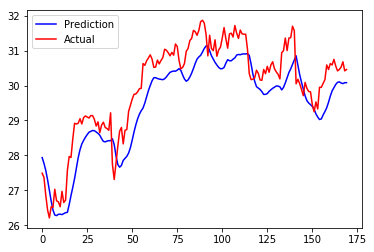

In [42]:
#  Line Plot of Actual Vs Predicted
plt.plot(new_pred,color='blue', label='Prediction')
plt.plot(new_y_test,color='red', label='Actual')
plt.legend(loc='best')
plt.show()

In [43]:
def estimation_error(actual, prediction):
    return (actual - prediction)**2

estimate_error = estimation_error(new_y_test, new_pred)
for e in estimate_error:
    print (e[0])

0.1992809922293742
0.16185887704439736
0.504293172477107
0.7459915613479388
0.6187908824893134
0.02739730351776575
0.005408619872812644
0.5420559858891633
0.17929434828652127
0.12793038176489513
0.04509544479647876
0.44265715794423166
0.10098771587014108
0.12947939230141278
1.4419945256193318
1.9037388409734495
1.1923213236439925
1.9173214186170997
2.502146763573423
1.5772843347449141
0.9755011882586567
0.7916911347140098
0.3311858837312345
0.42475154976826984
0.3732043482406901
0.2551143167483765
0.1650842554508798
0.20502298514163333
0.18265951775823427
0.10392787915994613
0.02951605370678247
0.10740826494417995
0.005389369167969875
0.15154226208274824
0.30205059869949996
0.17020830068406295
0.12937910421612547
0.08935050584206201
0.6388482838456878
0.5279180112447596
1.002252870700812
0.03741363594025035
0.27155992656719125
1.0568905904259231
1.183899776390196
0.22459740226085007
0.6487714136493221
0.5876900040230802
1.4240468722883735
1.455050290129394
1.3723845977627127
1.16668824

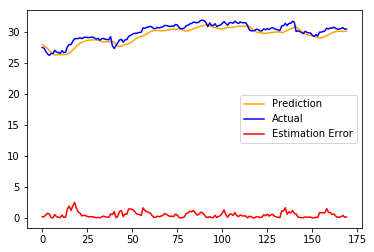

In [44]:
plt.plot(new_pred,color='orange', label='Prediction')
plt.plot(new_y_test,color='blue', label='Actual')
plt.plot(estimate_error,color='red', label='Estimation Error')
plt.legend(loc='best')
plt.show()

In [45]:
pd.concat([pd.DataFrame(new_pred), pd.DataFrame(new_y_test)], axis=1)

,0,0
0,27.936409,27.490000
1,27.772318,27.370001
2,27.570137,26.860001
3,27.303709,26.440001
4,26.996632,26.209999
...,...,...
165,30.105808,30.459999
166,30.072416,30.530001
167,30.056370,30.680000
168,30.082575,30.420000
